In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
import matplotlib.lines as mlines
from plot_spikes import *
from matplotlib.offsetbox import AnchoredText, HPacker, VPacker, TextArea, AnnotationBbox
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

# Debug

In [2]:
val, prob, sim, net = simulate('V', 0, 1, 0, trials=80, config='random', pert=0.0)

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


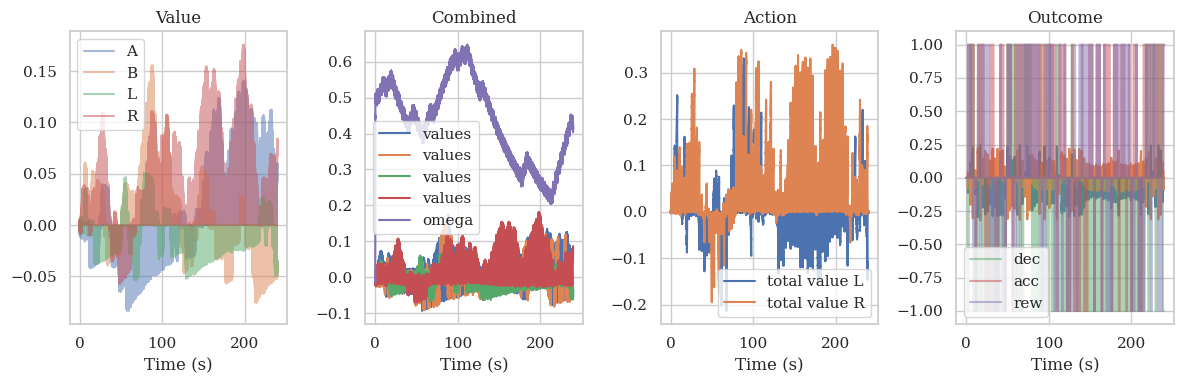

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
axes[0].plot(sim.trange(), sim.data[net.p_v][:,0], label='A', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,1], label='B', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,2], label='L', alpha=0.5)
axes[0].plot(sim.trange(), sim.data[net.p_v][:,3], label='R', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,:4], label='values')
axes[1].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='omega')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa][:,4], label='vwa')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,0], label='aL')
# axes[2].plot(sim.trange(), sim.data[net.p_vwa2][:,1], label='aR')
# axes[2].plot(sim.trange(), sim.data[net.p_w])
axes[2].plot(sim.trange(), sim.data[net.p_a][:,0], label='total value L')
axes[2].plot(sim.trange(), sim.data[net.p_a][:,1], label='total value R')
# axes[2].plot(sim.trange(), sim.data[net.p_thr], label='threshold')
axes[3].plot(sim.trange(), sim.data[net.p_ch])
axes[3].plot(sim.trange(), sim.data[net.p_dec][:,0], label='dec', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_dec][:,2], label='rt')
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc', alpha=0.5)
axes[3].plot(sim.trange(), sim.data[net.p_rew][:,0], label='rew', alpha=0.5)
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
# axes[0].set(xlim=[235,260])
axes[0].set(title='Value', xlabel="Time (s)")  # : 1s ITI, 1s Cue, 1s Rew
axes[1].set(title='Combined', xlabel="Time (s)")
axes[2].set(title='Action', xlabel="Time (s)")
axes[3].set(title='Outcome', xlabel="Time (s)")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout()
plt.show()
# fig.savefig("plots/dynamics_2.jpg", dpi=600)

### Loading

In [103]:
pd.read_pickle("data/nef/nef_data_probes.pkl.xz")

,monkey,session,block,time,va,vb,vl,vr,al,ar,w,dec,tdec,thr,rew,acc
0,V,0,1,0.001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.7,0.0,0.0
1,V,0,1,0.011,-0.004540,-0.002627,-0.002729,-0.002195,-0.002557,0.000106,-0.029319,0.0,0.000,0.7,0.0,0.0
2,V,0,1,0.021,-0.004932,0.001901,-0.003529,0.000327,0.001318,-0.000338,0.011371,0.0,0.000,0.7,0.0,0.0
3,V,0,1,0.031,-0.005006,0.000095,-0.002895,-0.000342,-0.000874,0.000675,0.072733,0.0,0.000,0.7,0.0,0.0
4,V,0,1,0.041,-0.005346,0.000809,-0.003337,-0.003271,-0.000293,-0.000987,0.130185,0.0,0.000,0.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,V,0,1,239.951,0.072222,-0.017686,-0.012927,0.109043,-0.000779,0.001427,0.711056,-1.0,0.736,0.7,1.0,1.0
119996,V,0,1,239.961,0.066257,-0.018685,-0.015761,0.108001,-0.000671,0.001249,0.705129,-1.0,0.736,0.7,1.0,1.0
119997,V,0,1,239.971,0.070717,-0.018504,-0.016766,0.110937,-0.000802,0.001607,0.709334,-1.0,0.736,0.7,1.0,1.0
119998,V,0,1,239.981,0.069370,-0.017372,-0.018775,0.108659,-0.000692,0.001220,0.704921,-1.0,0.736,0.7,1.0,1.0


# Spike raster

In [2]:
val, prob, sim, net = simulate('V', 0, 1, 0, trials=80, config='random', pert=0.0)

trial 1
trial 10
trial 20
trial 30
trial 40
trial 50
trial 60
trial 70
trial 80


In [18]:
times = sim.trange()
vwa_spikes = sim.data[net.s_vwa]
times2, vwa_spikes2 = preprocess_spikes(times, vwa_spikes, num=100)

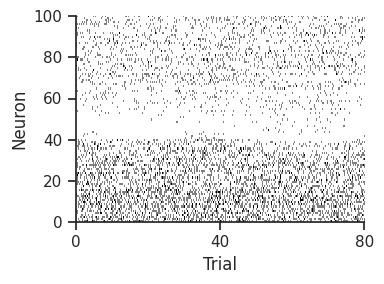

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
plot_spikes(times2, vwa_spikes2, ax=ax)
ax.set(ylabel='Neuron', xlabel='Trial', xticks=[0, 120, 240], xticklabels=[0,40,80])
plt.tight_layout()
plt.show()
fig.savefig("plots/spike_demo.svg")

# Load value and probe data files

In [3]:
def classify(row):
    b = row['block']
    if 1 <= b <= 12:
        # Letter blocks: check if it starts with A or B
        start = row['cor_let']
        return f"let_{start}{'B' if start == 'A' else 'A'}"
    elif 13 <= b <= 24:
        # Location blocks: check if starts with left or right
        start_init = 'L' if row['cor_loc'] == 'left' else 'R'
        end_init = 'R' if start_init == 'L' else 'L'
        return f"loc_{start_init}{end_init}"
    return "unknown"

In [4]:
def load_values(filename, do_acc=True, do_delta=True):
    df = pd.read_pickle(filename)
    emp = pd.read_pickle("data/empirical.pkl")
    if do_acc:
        df['acc'] = df['acc'].replace(-1, 0)
    if do_delta:
        df['dv_let'] = df['vwa_a'] - df['vwa_b']
        df['dv_loc'] = df['vwa_l'] - df['vwa_r']
        df['dv_let_abs'] = np.abs(df['vwa_a'] - df['vwa_b'])
        df['dv_loc_abs'] = np.abs(df['vwa_l'] - df['vwa_r'])
    block_starts = emp[emp['trial'] == 1].copy()
    block_starts['block_label'] = block_starts.apply(classify, axis=1)
    block_type_map = block_starts.set_index('block')['block_label'].to_dict()
    df['block_type'] = df['block'].map(block_type_map)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

In [5]:
def load_probes(filename, t_period=3.0):
    df = pd.read_pickle(filename)
    emp = pd.read_pickle("data/empirical.pkl")
    df['acc'] = df['acc'].replace(-1, 0)
    df['trial'] = (np.floor(df['time'] / t_period) + 1).astype(int)
    df['t_since_cue'] = df['time'] % t_period - 1.0
    emp_subset = emp[['monkey', 'session', 'block', 'trial', 'cor_loc', 'cor_let', 'block_type', 'reversal_at_trial']].drop_duplicates()
    join_keys = ['monkey', 'session', 'block', 'trial']
    df = df.merge(emp_subset, on=join_keys, how='left')
    df['rev'] = df['trial'] - df['reversal_at_trial']
    is_left = (df['cor_loc'] == 'left')
    df['acor'] = np.where(is_left, df['al'], df['ar'])
    df['ainc'] = np.where(is_left, df['ar'], df['al'])
    df['da'] = df['acor'] - df['ainc']
    for col in ['monkey', 'block_type', 'cor_loc', 'cor_let']:
        df[col] = df[col].astype('category')
    return df

In [6]:
nef_values = load_values("data/nef/pert/nef_data_values.pkl.xz")
# nef_probes = load_probes("data/nef/pert/nef_data_probes.pkl.xz")
rl_values = load_values("data/rl_values.pkl", do_acc=False, do_delta=False)

In [6]:
# rl_values

# Plot performance

In [218]:
def plot_performance(df, label):
    nef = df.copy()
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    nef['super_type'] = nef['block_type'].map(type_map).fillna(nef['block_type'])
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    sns.lineplot(data=nef.query("rev<0"), x='rev', y='acc', hue='super_type', hue_order=['what', 'where'], ax=axes)
    sns.lineplot(data=nef.query("rev>0"), x='rev', y='acc', hue='super_type', hue_order=['what', 'where'], ax=axes, legend=False)
    axes.set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1], yticks=[0.0, 0.25, 0.5, 0.75, 1.0],
             xticks=[-40, -20, 0, 20, 40], xticklabels=[-40, -20, '<rev>', 20, 40], xlabel="Trial")
    axes.axvline(0, color='black', linestyle='--', alpha=0.3)
    axes.legend(title='Block Type')
    axes.xaxis.grid(False)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance_{label}.pdf")
    fig.savefig(f"plots/performance_{label}.svg")
    fig.savefig(f"plots/performance_{label}.jpg", dpi=600)

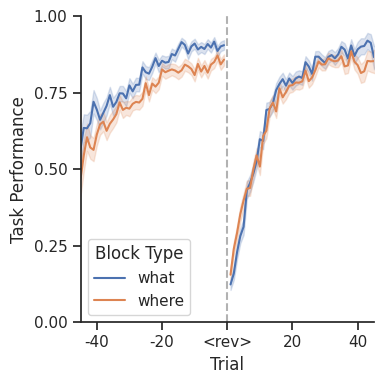

In [219]:
plot_performance(nef_values, "control")

# Plot performance and omega

In [7]:
def plot_performance_omega(df, label, window_size=7, x_ratio=0.7):
    nef = df.copy()
    emp = pd.read_pickle("data/empirical2.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    nef['super_type'] = nef['block_type'].map(type_map).fillna(nef['block_type'])
    nef['after_rev'] = nef['rev'] >= 0
    nef['smoothed_acc'] = nef.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])['acc'].transform(
        lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4), sharex=True,
                             sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})

    sns.lineplot(data=nef, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0])
    sns.lineplot(data=nef, x='rev', y='w', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    # axes[0].set_title(f'NEF Model ({label})')
    axes[0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1], yticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    axes[1].set(xlabel='Trial', xlim=[-40, 40], xticks=[-40, -20, 0, 20, 40], xticklabels=[-40, -20, '<rev>', 20, 40], ylabel=r'$\omega$', ylim=[0, 1])
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].legend(title='Block Type')
    axes[1].get_legend().remove()
    axes[0].xaxis.grid(False)  # Explicitly disable vertical lines
    axes[1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance__omega_{label}.pdf")
    fig.savefig(f"plots/performance__omega_{label}.svg")
    fig.savefig(f"plots/performance__omega_{label}.jpg", dpi=600)

# Plot performance and RT

In [179]:
def plot_performance_rt(df, label, window_size=3, x_ratio=0.5):
    nef = df.copy()
    emp = pd.read_pickle("data/empirical.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    nef['super_type'] = nef['block_type'].map(type_map).fillna(nef['block_type'])
    nef['scaled_rt'] = nef['tdec'] / 3

    # smooth empirical data
    pre_rev = emp.query("rev<0").copy()
    post_rev = emp.query("rev>=0").copy()
    pre_rev['smoothed_acc'] = pre_rev.groupby(['monkey', 'block_type', 'session', 'block'])['acc'].transform(
        lambda x: x.rolling(window=window_size, center=False, min_periods=1).mean())
    post_rev['smoothed_acc'] = post_rev.groupby(['monkey', 'block_type', 'session', 'block'])['acc'].transform(
        lambda x: x[::-1].rolling(window=window_size, center=False, min_periods=1).mean()[::-1])
    pre_rev['smoothed_rt'] = pre_rev.groupby(['monkey', 'block_type', 'session', 'block'])['rt'].transform(
        lambda x: x.rolling(window=window_size, center=False, min_periods=1).mean())
    post_rev['smoothed_rt'] = post_rev.groupby(['monkey', 'block_type', 'session', 'block'])['rt'].transform(
        lambda x: x[::-1].rolling(window=window_size, center=False, min_periods=1).mean()[::-1])
    emp_smoothed = pd.concat([pre_rev, post_rev])
    

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4), sharex=True,
                             sharey='row', gridspec_kw={'height_ratios': [x_ratio, 1 - x_ratio]})
    sns.lineplot(data=nef, x='rev', y='acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0])
    # sns.lineplot(data=nef, x='rev', y='tdec', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    sns.lineplot(data=nef, x='rev', y='scaled_rt', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    # sns.lineplot(data=emp, x='rev', y='acc', hue='block_type', hue_order=['what', 'where'], ax=axes[0], linestyle=":", legend=False)
    # sns.lineplot(data=emp, x='rev', y='rt', hue='block_type', hue_order=['what', 'where'], ax=axes[1], linestyle=":", legend=False)
    sns.lineplot(data=emp_smoothed, x='rev', y='smoothed_acc', hue='block_type', hue_order=['what', 'where'], ax=axes[0], linestyle=":", legend=False)
    sns.lineplot(data=emp_smoothed, x='rev', y='smoothed_rt', hue='block_type', hue_order=['what', 'where'], ax=axes[1], linestyle=":", legend=False)

    axes[0].set(xlim=[-45, 45], ylabel='Task Performance', ylim=[0, 1], yticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    axes[1].set(xlabel='Trial', xlim=[-40, 40], xticks=[-40, -20, 0, 20, 40], xticklabels=[-40, -20, '<rev>', 20, 40], ylabel='Response Time')
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].legend(title='Block Type')
    axes[1].get_legend().remove()
    axes[0].xaxis.grid(False)  # Explicitly disable vertical lines
    axes[1].xaxis.grid(False)  # Explicitly disable vertical lines

    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/performance_RT_{label}.pdf")
    fig.savefig(f"plots/performance_RT_{label}.svg")
    fig.savefig(f"plots/performance_RT_{label}.jpg", dpi=600)

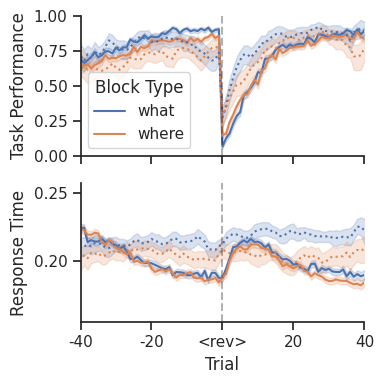

In [81]:
plot_performance_rt(nef_values, 'test')

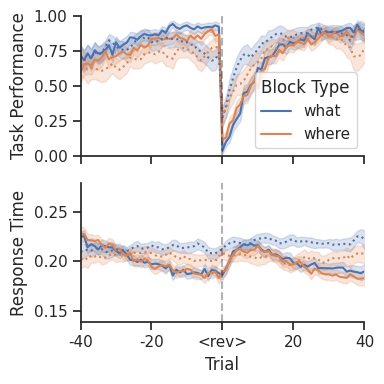

In [180]:
plot_performance_rt(nef_nopert, 'test')

# Plot value, omega, and RT dynamics

In [31]:
def set_colored_ylabel(ax, task_type, char_start, char_end):
    # Mapping characters to your specific palette indices
    color_map = {
        'A': palette[0],
        'B': palette[1],
        'L': palette[2],
        'R': palette[3]
    }
    
    # Create the bottom row components: "Char1", " → ", "Char2"
    t1 = TextArea(char_start, textprops=dict(color=color_map[char_start], fontweight='bold', size=11))
    t_arrow = TextArea(" \u2192 ", textprops=dict(size=11))
    t2 = TextArea(char_end, textprops=dict(color=color_map[char_end], fontweight='bold', size=11))
    
    # Pack the row horizontally
    row_arrow = HPacker(children=[t1, t_arrow, t2], align="center", pad=0, sep=0)
    
    # Create the top row: "What" or "Where"
    row_task = TextArea(task_type, textprops=dict(fontweight='bold', size=11))
    
    # Pack top and bottom rows vertically
    final_box = VPacker(children=[row_task, row_arrow], align="center", pad=0, sep=2)
    
    # Place it as the ylabel (axes fraction coordinates)
    # xy=(-0.3, 0.5) puts it to the left of the axis, vertically centered
    ab = AnnotationBbox(final_box, (-0.5, 0.5), xycoords='axes fraction',
                        frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

In [40]:
def plot_values(df, label):
    nef = df.copy()
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    name_map = {'va': 'A', 'vb': 'B', 'vl': 'L', 'vr': 'R'}
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 4), sharex=True, sharey="col")
    for row in range(4):
        if row==0: b_type='let_AB'
        if row==1: b_type='let_BA'
        if row==2: b_type='loc_LR'
        if row==3: b_type='loc_RL'
        block_data = nef.query("block_type==@b_type").copy()
        for col in range(3):
            if col==0: metrics = ['va', 'vb', 'vl', 'vr']
            if col==1: metrics = ['w']
            if col==2: metrics = ['tdec']
            for metric in metrics:
                label_name = name_map.get(metric, metric)
                sns.lineplot(data=block_data, x='rev', y=metric, ax=axes[row][col], label=label_name)
    
    for row in range(4):
        for col in range(3):
            axes[row][col].get_legend().remove()
            if row<3: axes[row][col].set(xlim=[-40, 40], xticks=[-40, 0, 40], ylabel=None)
            if row==3: axes[row][col].set(xlim=[-40, 40], xticks=[-40, 0, 40], xlabel='Trial', xticklabels=[-40, '<rev>', 40], ylabel=None)
            if row==0 and col==0: axes[row][col].set(title="values")
            if row==0 and col==1: axes[row][col].set(title=r"$\omega$")
            if row==0 and col==2: axes[row][col].set(title="RT")
            # if row==0 and col==0: axes[row][col].set_ylabel('What\nA \u2192 B', rotation=0, labelpad=30, verticalalignment='center')
            # if row==1 and col==0: axes[row][col].set_ylabel('What\nB \u2192 A', rotation=0, labelpad=30, verticalalignment='center')
            # if row==2 and col==0: axes[row][col].set_ylabel('What\nL \u2192 R', rotation=0, labelpad=30, verticalalignment='center')
            # if row==3 and col==0: axes[row][col].set_ylabel('What\nR \u2192 L', rotation=0, labelpad=30, verticalalignment='center')
            if row==0 and col==0: set_colored_ylabel(axes[row][col], "What", "A", "B")
            if row==1 and col==0: set_colored_ylabel(axes[row][col], "What", "B", "A")
            if row==2 and col==0: set_colored_ylabel(axes[row][col], "Where", "L", "R")
            if row==3 and col==0: set_colored_ylabel(axes[row][col], "Where", "R", "L")
            if col==0: axes[row][col].set(ylim=[-0.05,0.13], yticks=[0,0.13])
            if col==1: axes[row][col].set(ylim=[0.3,0.7], yticks=[0.3,0.5,0.7])
            if col==2: axes[row][col].set(ylim=[0.5,0.7], yticks=[0.5,0.7])
            if col==1: axes[row][col].axhline(0.5, linestyle="--", color='k', alpha=0.5)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/values_{label}.pdf")
    fig.savefig(f"plots/values_{label}.svg")
    fig.savefig(f"plots/values_{label}.jpg", dpi=600)

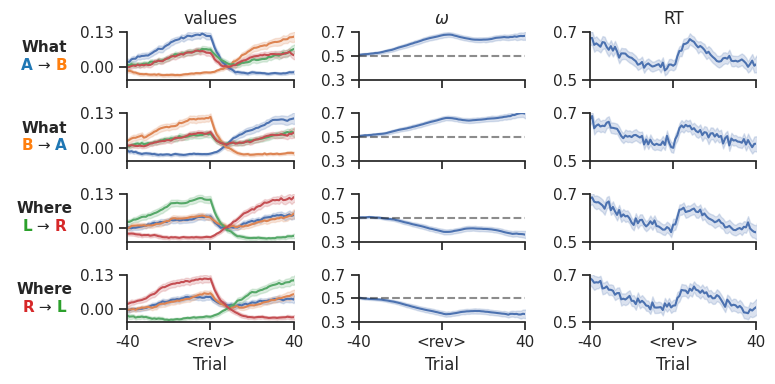

In [41]:
plot_values(nef_values.query("pert==0.0"), label='control')

# Plot total value accumulation within a trial

In [14]:
def plot_ramp(nef, label, trial_start=38, trial_end=45):
    df = nef.query("@trial_start <= rev < @trial_end").copy()
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    sns.lineplot(df, x='t_since_cue', y='da', hue='block_type', ax=axes, color=palette[:2])
    axes.set(xlabel='Time from Cue (s)', ylabel="Total Value")
    axes.axvline(0, color='black', linestyle='--', alpha=0.3)
    axes.set_xticks(np.linspace(-1,1,5))
    axes.set_xlim([-1, 1])
    axes.legend(title="Block Type")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/ramp_{label}.pdf")
    fig.savefig(f"plots/ramp_{label}.svg")
    fig.savefig(f"plots/ramp_{label}.jpg", dpi=600)

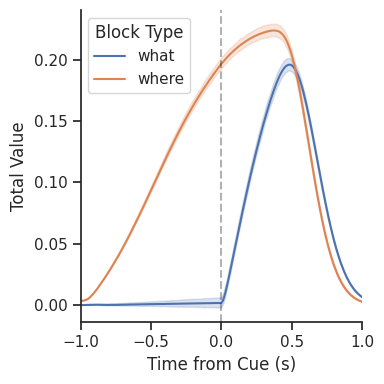

In [16]:
# plot_ramp(nef_probes.query("pert==0.0"), label='control')
plot_ramp(nef_probes, label='control')

# DV perturbed vs control

In [45]:
def plot_dv_pert_vs_ctrl(df, label):
    nef = df.copy()
    fig, ax1 = plt.subplots(figsize=(4, 4))
    ax2 = ax1.twinx()
    scatter_settings = {'alpha': 0.05, 's': 0.1}
    perts = [-0.2, -0.1, 0.0, 0.1, 0.2]
    labels = ["-0.2", "-0.1", "control", "0.1", "0.2"]
    identifiers = ['monkey', 'session', 'block', 'seed', 'trial']
    df_ctrl = nef.query("pert == 0.0")
    for i, p in enumerate(perts):
        df_pert = nef.query("pert == @p")
        aligned = pd.merge(df_ctrl, df_pert, on=identifiers, suffixes=('_base', '_pert'))
        x_data = aligned['dv_let_base']
        x_data2 = aligned['dv_loc_base']
        y_data = aligned['dv_let_pert']
        y_data2 = aligned['dv_loc_pert']
        sns.regplot(x=x_data, y=y_data, ax=ax1, color=palette[i], label=labels[i], scatter_kws=scatter_settings,
                    marker='o', line_kws={'linestyle': '-'})
        sns.regplot(x=x_data2, y=y_data2, ax=ax2, color=palette[i], label=labels[i], scatter_kws=scatter_settings,
                    marker='s', line_kws={'linestyle': '--'})
    ax1.set(ylabel=r'Perturbed $\Delta V$', xlabel=r'Control $\Delta V$', 
                xlim=[-0.4, 0.4], ylim=[-0.4, 0.4])
    # ax2.set(ylabel=r'Perturbed $\Delta V$', ylim=[-0.4, 0.4])
    ax2.set(ylabel=None, yticks=[], ylim=[-0.4, 0.4])
    
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.pdf")
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.svg")
    fig.savefig(f"plots/dv_pert_vs_ctrl_{label}.jpg", dpi=600)

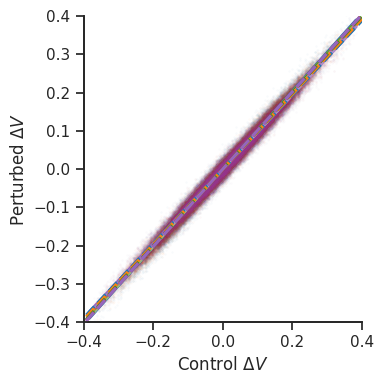

In [46]:
plot_dv_pert_vs_ctrl(nef_values, label='single')

# Decision perturbed vs control

In [48]:
def plot_dec_pert_vs_ctrl(df, label):
    nef = df.copy()
    perts = [-0.2, -0.1, 0.0, 0.1, 0.2]
    labels = ["-0.2", "-0.1", "control", "0.1", "0.2"]
    identifiers = ['monkey', 'session', 'block', 'seed', 'trial']
    df_ctrl = nef.query("pert == 0.0")
    n_samples = len(df_ctrl)
    results = []
    for p in perts:
        if p==0: continue
        df_pert = nef.query("pert == @p")
        aligned = pd.merge(df_ctrl, df_pert, on=identifiers, suffixes=('_base', '_pert'))
        is_different = (aligned['dec_base'] != aligned['dec_pert'])
        prob_diff = is_different.mean() * 100
        results.append({'Perturbation': p, 'Percentage': prob_diff})
    plot_df = pd.DataFrame(results)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    pal2 = [palette[0], palette[1], palette[3], palette[4]]
    sns.barplot(data=plot_df, x='Perturbation', y='Percentage', ax=axes, palette=pal2, hue='Perturbation', legend=False)
    for p_bar in axes.patches:
        height = p_bar.get_height()
        axes.annotate(f'{height:.1f}%', (p_bar.get_x() + p_bar.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 7), textcoords='offset points')
    axes.set(ylabel="Perturbed Model\nChooses Differently (% trials)", xlabel=r"Perturbation ($\Delta \omega$)", ylim=[0,18], yticks=[0,6,12,18])
    # axes.set_title("Choice Differences Following Perturbation", pad=20)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.pdf")
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.svg")
    fig.savefig(f"plots/dec_pert_vs_ctrl_{label}.jpg", dpi=600)

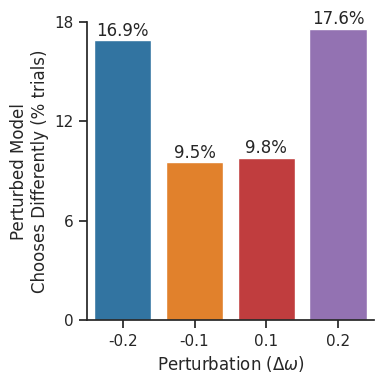

In [49]:
plot_dec_pert_vs_ctrl(nef_values, label='single')

# Alignment between value and choice axes

In [181]:
def plot_alignment_by_omega(df, label, n_omega_bins=5,
                            perts=[-0.2, -0.1, 0.0, 0.1, 0.2],
                            labels=["-0.2", "-0.1", "control", "0.1", "0.2"],
                            p2=[palette[0], palette[1], palette[2], palette[3], palette[4]]):
    fig, axes = plt.subplots(nrows=2, ncols=n_omega_bins, figsize=(12, 4), sharex=True, sharey=True)
    nef = df.copy()
    nef['w_quantile'] = pd.qcut(nef['w'], n_omega_bins, labels=False)
    nef['dv_tot'] = nef['al'] - nef['ar']
    identifiers = ['monkey', 'session', 'block', 'seed', 'trial']
    for q in range(n_omega_bins):
        for i, p in enumerate(perts):
            df_ctrl = nef.query("w_quantile==@q & pert==0.0")
            df_pert = nef.query("pert==@p")
            aligned = pd.merge(df_ctrl, df_pert, on=identifiers, suffixes=('_base', '_pert'))
            sns.regplot(aligned, x='dv_loc_pert', y='dv_tot_pert', ax=axes[0][q], color=p2[i], scatter=False)
            sns.regplot(aligned, x='dv_let_pert', y='dv_tot_pert', ax=axes[1][q], color=p2[i], scatter=False)
            sns.regplot(aligned.sample(frac=0.05, random_state=42), x='dv_loc_pert', y='dv_tot_pert', ax=axes[0][q], color=p2[i], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
            sns.regplot(aligned.sample(frac=0.05, random_state=42), x='dv_let_pert', y='dv_tot_pert', ax=axes[1][q], color=p2[i], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
        axes[0][q].set(title=fr"$\omega_{q+1}$", ylabel=None, xlabel=r'$\Delta V_{act}$')
        axes[1][q].set(ylabel=None, xlabel=r'$\Delta V_{stim}$')
    axes[0][0].set(ylabel=r'$\Delta V_{total}$', xlim=[-0.6, 0.6], ylim=[-0.6, 0.6], xticks=[-0.6, 0, 0.6], yticks=[-0.6,0,0.6])
    axes[1][0].set(ylabel=r'$\Delta V_{total}$', xlim=[-0.6, 0.6], ylim=[-0.6, 0.6], xticks=[-0.6, 0, 0.6], yticks=[-0.6,0,0.6])
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/alignment_{label}.pdf")
    fig.savefig(f"plots/alignment_{label}.svg")
    fig.savefig(f"plots/alignment_{label}.jpg", dpi=600)

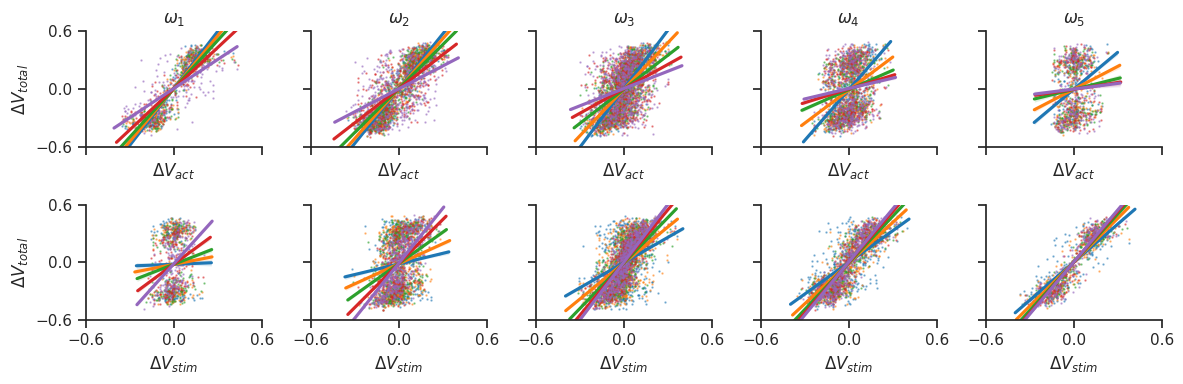

In [63]:
plot_alignment_by_omega(nef_values, label='w_before_pert')

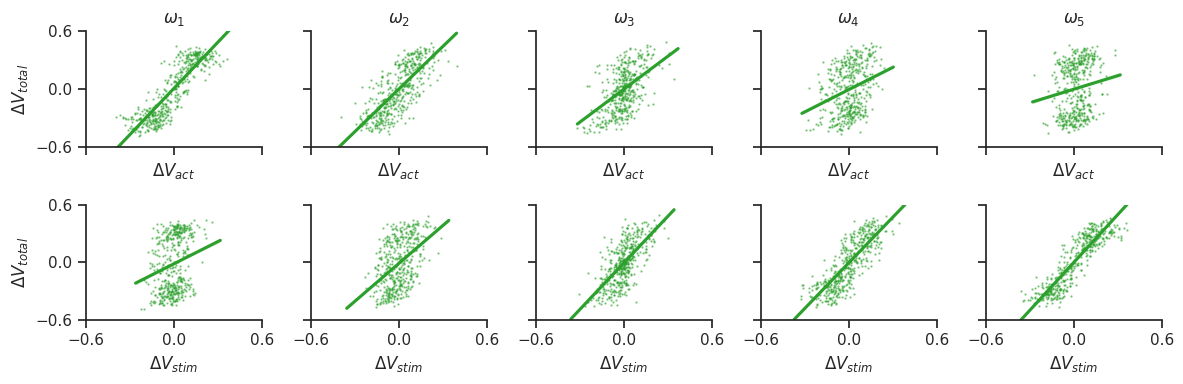

In [182]:
plot_alignment_by_omega(nef_nopert, label='test')

# Reward

## Delta Q vs Reward

In [159]:
nef_nopert = load_values("data/nef/nopert/nef_data_values.pkl.xz")

In [374]:
def plot_dv_vs_rew_omega(df, n_omega_bins=5):
    nef = df.copy().query("trial>1")
    nef['w_quantile'] = pd.qcut(nef['w'], n_omega_bins, labels=False)
    nef['dvlet_v'] = np.abs(nef['va'] - nef['vb'])
    nef['dvloc_v'] = np.abs(nef['vl'] - nef['vr'])
    nef['dvlet_vwa'] = np.abs(nef['vwa_a'] - nef['vwa_b'])
    nef['dvloc_vwa'] = np.abs(nef['vwa_l'] - nef['vwa_r'])
    identifiers = ['monkey', 'session', 'block', 'seed']
    nef['rew_tm1'] = nef.groupby(identifiers)['rew'].shift(1)
    nef['dva'] = nef.groupby(identifiers)['va'].diff()
    nef['dvb'] = nef.groupby(identifiers)['vb'].diff()
    nef['dvl'] = nef.groupby(identifiers)['vl'].diff()
    nef['dvr'] = nef.groupby(identifiers)['vr'].diff()
    nef['ddvlet'] = nef.groupby(identifiers)['dvlet_vwa'].diff()
    nef['ddvloc'] = nef.groupby(identifiers)['dvloc_vwa'].diff()

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 3), sharex='row', sharey='row')
    sns.barplot(nef, x='w_quantile', y='dva', hue='rew_tm1', ax=axes[0], palette=palette[:2])
    sns.barplot(nef, x='w_quantile', y='dvb', hue='rew_tm1', ax=axes[1], palette=palette[:2])
    sns.barplot(nef, x='w_quantile', y='dvl', hue='rew_tm1', ax=axes[2], palette=palette[:2])
    sns.barplot(nef, x='w_quantile', y='dvr', hue='rew_tm1', ax=axes[3], palette=palette[:2])
    axes[0].set(ylabel=r'Update to $|\Delta V|$')
    axes[0].set(title=r'$V_{A}$')
    axes[1].set(title=r'$V_{B}$')
    axes[2].set(title=r'$V_{L}$')
    axes[3].set(title=r'$V_{R}$')
    axes[0].legend(title='Reward')
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    axes[3].get_legend().remove()
    axes[0].set(xlabel=None, xticks=[0,1,2,3,4], xticklabels=[fr"$\omega_{q+1}$" for q in range(n_omega_bins)])
    axes[1].set(xlabel=None)
    axes[2].set(xlabel=None)
    axes[3].set(xlabel=None)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharex='row', sharey='row')
    sns.barplot(nef, x='w_quantile', y='ddvlet', hue='rew_tm1', ax=axes[0], palette=palette[:2])
    sns.barplot(nef, x='w_quantile', y='ddvloc', hue='rew_tm1', ax=axes[1], palette=palette[:2])
    axes[0].set(ylabel=r'Update to $|\Delta V|$', title=r'$\Delta V_{stim}$')
    axes[1].set(title=r'$\Delta V_{act}$')
    axes[1].legend(title='Reward')
    axes[0].get_legend().remove()
    axes[0].set(xlabel=None, xticks=[0,1,2,3,4], xticklabels=[fr"$\omega_{q+1}$" for q in range(n_omega_bins)])
    axes[1].set(xlabel=None)
    plt.tight_layout()
    plt.show()

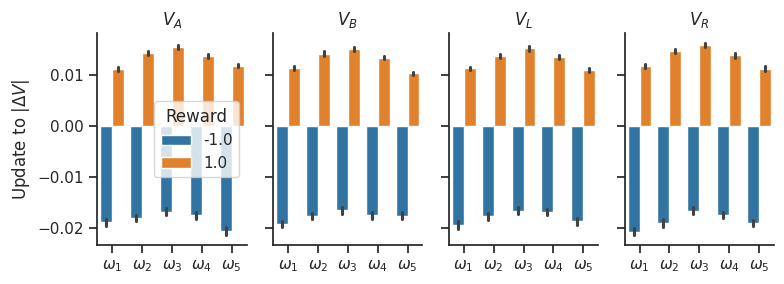

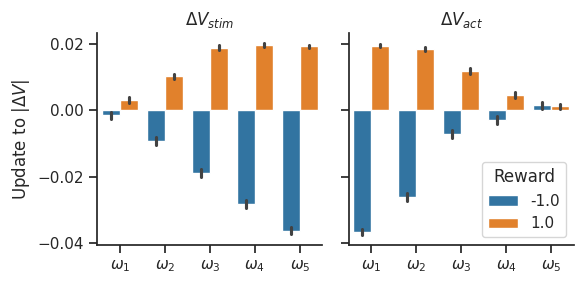

In [375]:
plot_dv_vs_rew_omega(nef_nopert)

In [418]:
def plot_dv_vs_pe_omega(df, label, n_omega_bins=5):
    nef = df.copy().query("trial>1")
    nef['w_quantile'] = pd.qcut(nef['w'], n_omega_bins, labels=False)
    nef['dvlet_v'] = np.abs(nef['va'] - nef['vb'])
    nef['dvloc_v'] = np.abs(nef['vl'] - nef['vr'])
    nef['dvlet_vwa'] = np.abs(nef['vwa_a'] - nef['vwa_b'])
    nef['dvloc_vwa'] = np.abs(nef['vwa_l'] - nef['vwa_r'])
    
    identifiers = ['monkey', 'session', 'block', 'seed']
    nef['rew_tm1'] = nef.groupby(identifiers)['rew'].shift(1)
    nef['vapec_tm1'] = nef.groupby(identifiers)['vapec'].shift(1)
    nef['vbpec_tm1'] = nef.groupby(identifiers)['vbpec'].shift(1)
    nef['vlpec_tm1'] = nef.groupby(identifiers)['vlpec'].shift(1)
    nef['vrpec_tm1'] = nef.groupby(identifiers)['vrpec'].shift(1)
    nef['vapeu_tm1'] = nef.groupby(identifiers)['vapeu'].shift(1)
    nef['vbpeu_tm1'] = nef.groupby(identifiers)['vbpeu'].shift(1)
    nef['vlpeu_tm1'] = nef.groupby(identifiers)['vlpeu'].shift(1)
    nef['vrpeu_tm1'] = nef.groupby(identifiers)['vrpeu'].shift(1)
    nef['dva'] = nef.groupby(identifiers)['va'].diff()
    nef['dvb'] = nef.groupby(identifiers)['vb'].diff()
    nef['dvl'] = nef.groupby(identifiers)['vl'].diff()
    nef['dvr'] = nef.groupby(identifiers)['vr'].diff()
    nef['ddvlet'] = nef.groupby(identifiers)['dvlet_vwa'].diff()
    nef['ddvloc'] = nef.groupby(identifiers)['dvloc_vwa'].diff()
    nef['ddvlet_pe'] = nef['vapec_tm1'] + nef['vbpec_tm1']
    nef['ddvloc_pe'] = nef['vlpec_tm1'] + nef['vrpec_tm1']

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3), sharey=True)
    for q in range(n_omega_bins):
        nef_w = nef.query("w_quantile==@q")
        sns.regplot(nef_w, x='vapec_tm1', y='dva', ax=axes[0], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w, x='vbpec_tm1', y='dvb', ax=axes[1], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w, x='vlpec_tm1', y='dvl', ax=axes[2], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w, x='vrpec_tm1', y='dvr', ax=axes[3], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='vapec_tm1', y='dva', ax=axes[0],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='vbpec_tm1', y='dvb', ax=axes[1],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='vlpec_tm1', y='dvl', ax=axes[2],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='vrpec_tm1', y='dvr', ax=axes[3],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
    axes[0].legend()
    axes[0].set(ylabel=r'Update to $V_{x}$', xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_A$")
    axes[1].set(ylabel=None, xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_B$")
    axes[2].set(ylabel=None, xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_L$")
    axes[3].set(ylabel=None, xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_R$")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=True)
    for q in range(n_omega_bins):
        nef_w = nef.query("w_quantile==@q")
        sns.regplot(nef_w, x='ddvlet_pe', y='ddvlet', ax=axes[0], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w, x='ddvloc_pe', y='ddvloc', ax=axes[1], color=palette[q], label=fr"$\omega_{q+1}$", scatter=False)
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='ddvlet_pe', y='ddvlet', ax=axes[0],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
        sns.regplot(nef_w.sample(frac=0.05, random_state=42), x='ddvloc_pe', y='ddvloc', ax=axes[1],
            color=palette[q], fit_reg=False, scatter_kws={'alpha': 0.5, 's': 0.5})
    axes[0].legend()
    axes[0].set(ylabel=r'Update to $V_{x}$', xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_{stim}$")
    axes[1].set(ylabel=None, xlabel="Prediction Error " + r"($R - V_{x}$)", title=r"$V_{act}$")
    plt.tight_layout()
    plt.show()

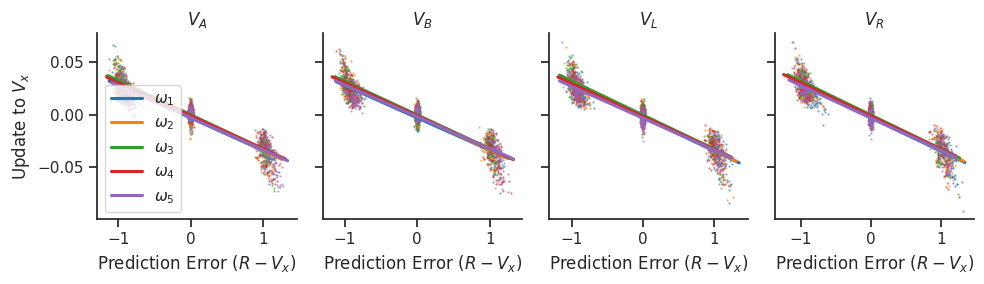

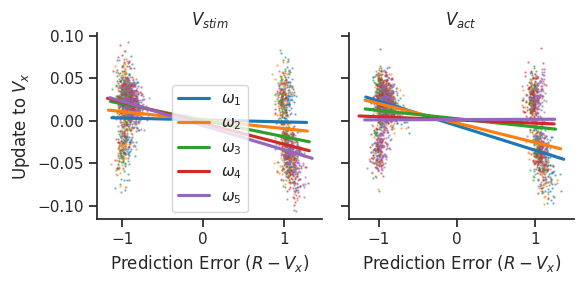

In [419]:
plot_dv_vs_pe_omega(nef_nopert, 'test')

# Stand alone perturbation legend

In [167]:
def plot_standalone_legend(perts=[-0.2, -0.1, 0.0, 0.1, 0.2], labels=["-0.2", "-0.1", "control", "0.1", "0.2"]):
    fig, ax = plt.subplots(figsize=(4, 2))
    legend_handles = []
    for i, p in enumerate(perts):
        line = mlines.Line2D([], [], color=palette[i], marker='o', linestyle='-', markersize=8, label=labels[i])
        legend_handles.append(line)
    legend = ax.legend(handles=legend_handles, 
                       title=r"Perturbation ($\Delta \omega$)", 
                       loc='center', 
                       frameon=True)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig("plots/pert_legend.svg")

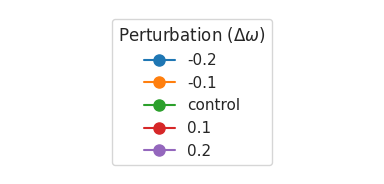

In [168]:
plot_standalone_legend()

In [42]:
def plot_variable_legend_standalone():
    fig, ax = plt.subplots(figsize=(2, 1))
    let_proxy = mlines.Line2D([], [], color='gray', marker='o', 
                              linestyle='-', label='Stimulus')
    loc_proxy = mlines.Line2D([], [], color='gray', marker='s', 
                              linestyle='--', label='Action')
    ax.legend(handles=[let_proxy, loc_proxy], 
              title='Variable', 
              loc='center', 
              frameon=True)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(f"plots/legend_variable.pdf", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/legend_variable.svg", bbox_inches='tight', transparent=True)

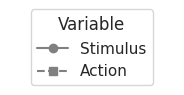

In [43]:
plot_variable_legend_standalone()